In [1]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import quantile_transform
from sklearn import preprocessing
from gudhi import RipsComplex
from gudhi import SimplexTree
from gudhi.weighted_rips_complex import WeightedRipsComplex
import gudhi.representations
import pandas as pd 
import numpy as np
import sklearn
import gudhi
import random
import math
import dcor 
import os

In [828]:
#Read TCGA Data Renal, Breast and Colorectal Cancer

In [829]:
def read_files_create_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    df.columns = [ref] * df.shape[1]
    
    df = df.T
    df = df.drop(columns=np.nan)
    
    biomarker_genes = '/Users/lebohangmashatola/downloads/CRCPhenotypePredictionTool-main/biomarkers/cholesterol_metabolism.csv'
    #CSC.csv - moderate
    #DNA_replication.csv - high highest
    #dna_damage.csv - high
    #CRC.csv
    #cancer.csv
    #p53.csv - high betti-0 highest
    
    biomarkers = pd.read_csv(biomarker_genes, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()   
    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)] #Subset biomarker genes
    
    return(gene_exprs_matrix)

In [830]:
GSE19860_R = read_files_create_dataframe('GSE19860_RESISTANT_FOLFOX.csv', 'r')
GSE19860_S = read_files_create_dataframe('GSE19860_SENSITIVE_FOLFOX.csv', 's')

GSE28702_R = read_files_create_dataframe('GSE28702_RESISTANT_FOLFOX.csv', 'r')
GSE28702_S = read_files_create_dataframe('GSE28702_SENSITIVE_FOLFOX.csv', 's')

GSE52735_R = read_files_create_dataframe('GSE52735_RESISTANT_FOLFOX.csv', 'r')
GSE52735_S = read_files_create_dataframe('GSE52735_SENSITIVE_FOLFOX.csv', 's')

GSE69657_R = read_files_create_dataframe('GSE69657_RESISTANT_FOLFOX.csv', 'r')
GSE69657_S = read_files_create_dataframe('GSE69657_SENSITIVE_FOLFOX.csv', 's')

GSE72968_R = read_files_create_dataframe('GSE72968_RESISTANT_FOLFOX.csv', 'r')
GSE72968_S = read_files_create_dataframe('GSE72968_SENSITIVE_FOLFOX.csv', 's')

In [831]:
array_r = pd.concat([GSE19860_R, GSE28702_R, GSE52735_R, GSE69657_R, GSE72968_R], axis=0)
array_r = quantile_transform(array_r, n_quantiles=5, random_state=0, copy=True)
array_r = np.array(array_r)

array_s = pd.concat([GSE19860_S, GSE28702_S, GSE52735_S, GSE69657_S, GSE72968_S], axis=0)
array_s = quantile_transform(array_s, n_quantiles=5, random_state=0, copy=True)
array_s = np.array(array_s)

In [832]:
GSE81653_R = read_files_create_dataframe('GSE81653_FOLFOX_RESISTANT.csv', 'r')
GSE81653_S = read_files_create_dataframe('GSE81653_FOLFOX_SENSITIVE.csv', 's')

In [833]:
GSE81653_R = np.array(GSE81653_R)
GSE81653_S = np.array(GSE81653_S)

In [834]:
def read_files_rna_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    
    biomarker_genes = '/Users/lebohangmashatola/downloads/CRCPhenotypePredictionTool-main/biomarkers/cholesterol_metabolism.csv'
    #CSC.csv
    #DNA_replication.csv
    #cholesterol_metabolism.csv
    #dna_damage.csv
    
    biomarkers = pd.read_csv(biomarker_genes, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()   
    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)] #Subset biomarker genes
    
    return(np.array(gene_exprs_matrix))

In [835]:
R = read_files_rna_dataframe('rnaseq_folfox_r.csv', 'r')
S = read_files_rna_dataframe('rnaseq_folfox_s.csv', 's')

In [836]:
stage1 = read_files_rna_dataframe('stage1.csv', 'r')
stage4 = read_files_rna_dataframe('stage4.csv', 's')

In [837]:
#Construct a distance correlations matrix for each disease and non-disease dataset

In [838]:
def intergene_correlation_measure(DF):
    
    num_genes = DF.shape[1]
    dist = np.zeros((num_genes, num_genes))
    
    for i in range(num_genes):
        for j in range(i+1, num_genes):
            
            dist[i,j] = dcor.distance_correlation(DF[:,i], DF[:,j]) #Distance Correlations 
    
    dist = dist + dist.T + np.eye(num_genes)
    
    return 1 - dist

In [839]:
M_R = intergene_correlation_measure(R.T)

In [840]:
M_S = intergene_correlation_measure(S.T)

In [841]:
M_stage1= intergene_correlation_measure(stage1.T)

In [842]:
M_stage4= intergene_correlation_measure(stage4.T)

In [843]:
M_GSE81653_R = intergene_correlation_measure(GSE81653_R.T)

In [844]:
M_GSE81653_S = intergene_correlation_measure(GSE81653_S.T)

In [845]:
M_array_r = intergene_correlation_measure(array_r.T)

In [846]:
M_array_s = intergene_correlation_measure(array_s.T)

In [847]:
#Construct persistent diagrams for each disease and non-disease distance correlations matrix

In [848]:
def persistent_diagram(M_train, M_test):
    
    rips_complex_training = RipsComplex(M_train).create_simplex_tree(max_dimension=1)
    rips_complex_training.collapse_edges()
    rips_complex_training.expansion(3)
    rips_complex_training.persistence(persistence_dim_max=True)
    
    rips_complex_testing = RipsComplex(M_test).create_simplex_tree(max_dimension=1)
    rips_complex_testing.collapse_edges()
    rips_complex_testing.expansion(3)
    rips_complex_testing.persistence(persistence_dim_max=True)
        
    gudhi.plot_persistence_diagram(rips_complex_training.persistence(persistence_dim_max=False), legend=True, fontsize=12)
    gudhi.plot_persistence_diagram(rips_complex_testing.persistence(persistence_dim_max=False), legend=True, fontsize=12)

    
#Determine the wasserstein distance between two persistent diagram

    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(0)])
    wd_0 = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(0)])
    
    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(1)])
    wd_1 = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(1)])
    
    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(2)])
    wd_2 = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(2)])
        
    print("Wasserstein Distance (Betti-0): " + str(wd_0[0][0]))
    print("Wasserstein Distance (Betti-1): " + str(wd_1[0][0]))
    print("Wasserstein Distance (Betti-2): " + str(wd_2[0][0]))

Wasserstein Distance (Betti-0): 1.7706191935326192
Wasserstein Distance (Betti-1): 0.024127303314747328
Wasserstein Distance (Betti-2): 0.0


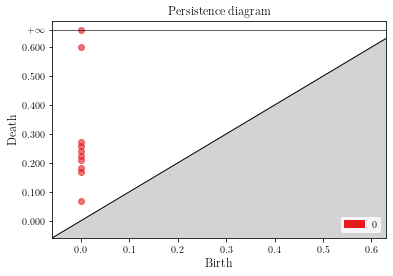

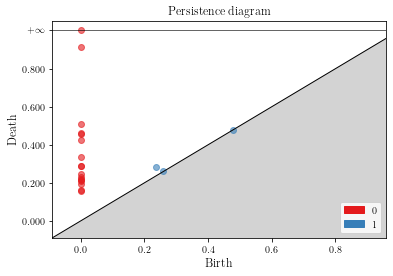

In [849]:
persistent_diagram(M_R, M_S) 

Wasserstein Distance (Betti-0): 5.413126705961571
Wasserstein Distance (Betti-1): 1.4185384653311313
Wasserstein Distance (Betti-2): 0.16797204460576526


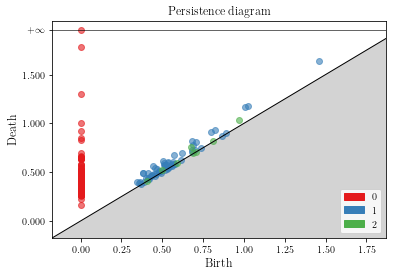

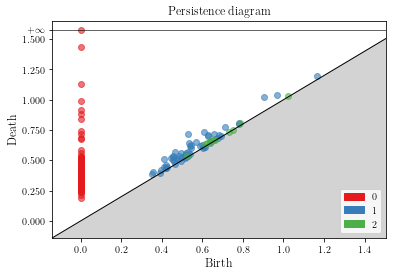

In [850]:
persistent_diagram(M_stage1, M_stage4) 

Wasserstein Distance (Betti-0): 40.113927389386
Wasserstein Distance (Betti-1): 3.7698185936772335
Wasserstein Distance (Betti-2): 1.1310014953854672


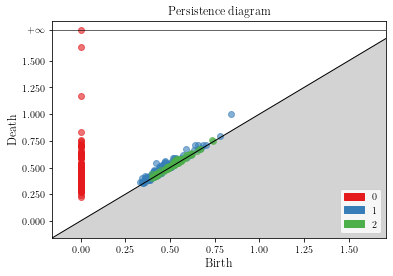

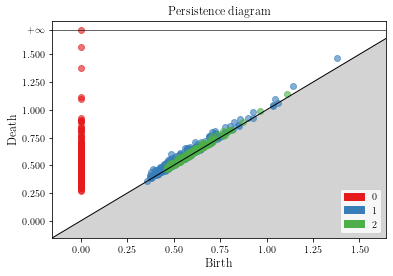

In [851]:
persistent_diagram(M_GSE81653_R, M_GSE81653_S) 

Wasserstein Distance (Betti-0): 10.14292249875042
Wasserstein Distance (Betti-1): 2.3558322627720845
Wasserstein Distance (Betti-2): 1.5911653139855477


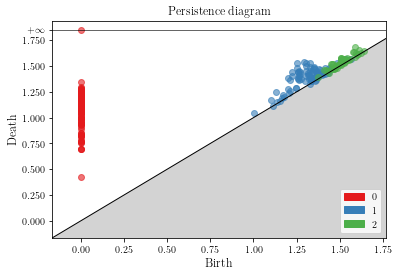

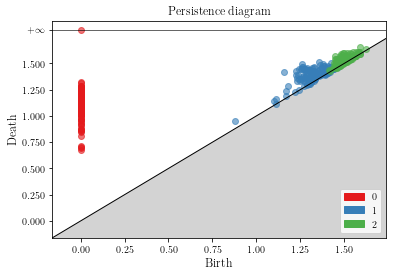

In [852]:
persistent_diagram(M_array_r, M_array_s) 